In [210]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# mnist dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms

from dataset_tools import OwnDataset, make_train_test_val_split, make_small_subset
from plotting import (
    plot_split_stratification,
    show_img, 
    loss_plots, 
    plot_random_images, 
    plot_image_comparison, 
    plot_latent_train, 
    plot_latent)
from collections import defaultdict


cuda = torch.cuda.is_available()
print(cuda)

from sklearn.neighbors import KNeighborsClassifier

True


In [211]:
tf = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    # transforms.Lambda(lambda x: x.view(-1)) # notice that we dont flatten when we are going to use CNN
])
# dataset = OwnDataset(transform=tf)
dataset = OwnDataset(transform=tf, path=r"C:\Users\Otto\Desktop\Fagprojekt_data\labelled_data")
# train_subset, test_subset, val_subset = make_train_test_val_split(dataset)

train_subset = make_small_subset(dataset, 10000)
test_subset = make_small_subset(dataset, 5000)
val_subset = make_small_subset(dataset, 5000)

# batch size whole dataset

train_loader = DataLoader(train_subset, batch_size=len(train_subset), shuffle=True, pin_memory=cuda)
test_loader = DataLoader(test_subset, batch_size=(len(test_subset)), shuffle=True, pin_memory=cuda)
# test_loader = DataLoader(test_subset, batch_size=64, shuffle=True, pin_memory=cuda)
val_loader = DataLoader(val_subset, batch_size=len(val_subset), shuffle=True)

print(len(dataset), len(train_loader), len(test_loader), len(val_loader))

488396 1 1 1


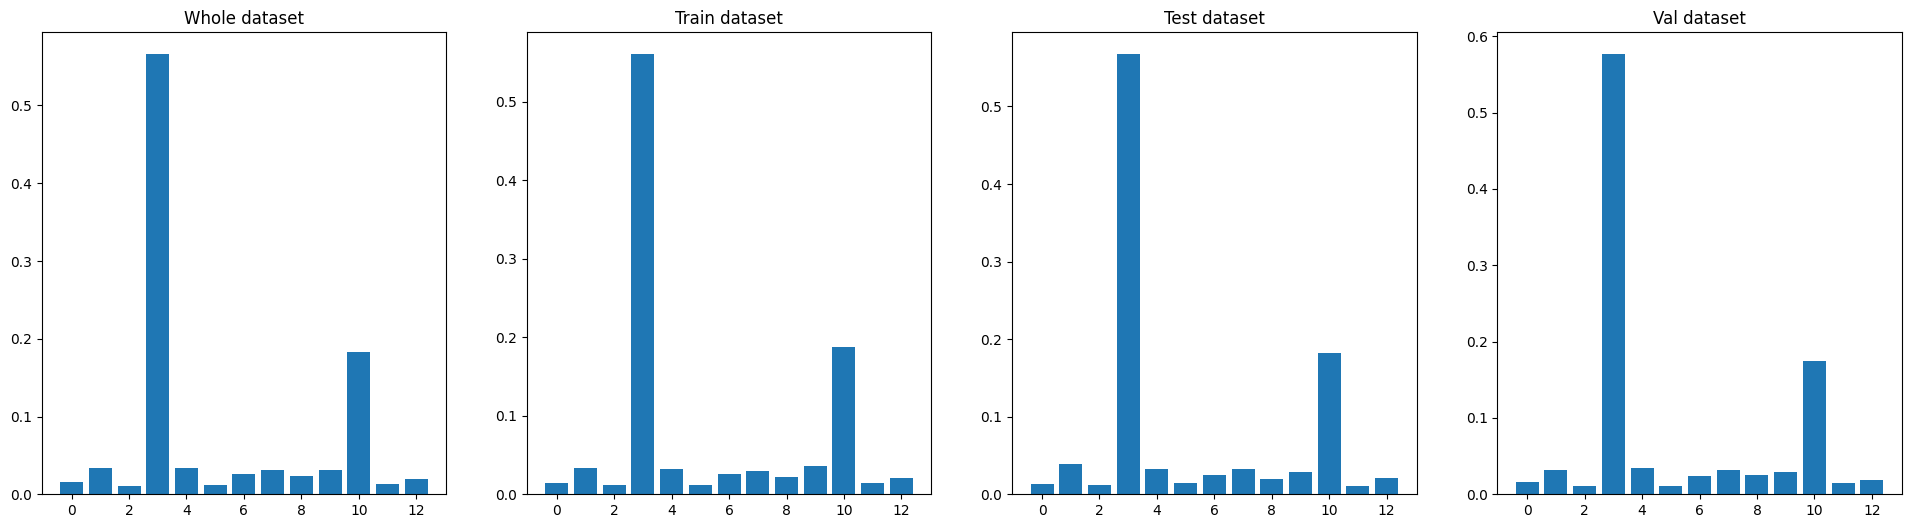

In [212]:
plot_split_stratification(dataset, train_subset, test_subset, val_subset)

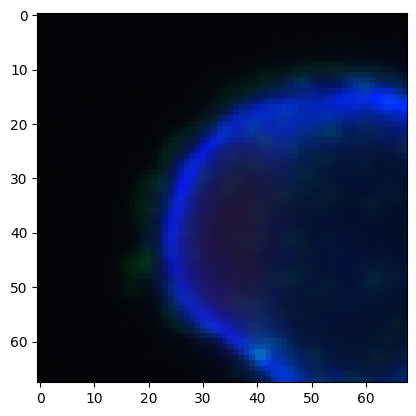

'Actin disruptors'

In [213]:
# get a sample image from the dataset
sample = dataset[612][0]
label = dataset[612][1]

# show the image
show_img(sample.view(3,68,68))

# moa
# data_train.dataset.class_to_idx
dataset.dataset.classes[label]


In [214]:
from models import LatentClassifier, VAE_CELL_CNN, LatentClassifier_2

# load pre-trained model
latent_dim = 256
hidden_dim = 2*latent_dim

# define dirs for the saving of model / data
MODEL_DIR = "trained_models/"
TRAIN_DATA_DIR = "train_data/"

vae = VAE_CELL_CNN(input_dim=(3,68,68), hidden_dim=hidden_dim, latent_dim=latent_dim)
# vae.load_state_dict(torch.load(MODEL_DIR + f"VAE_CELL_CNN_latent{latent_dim}_mean_best_model.pth"))
vae.load_state_dict(torch.load(MODEL_DIR + f"VAE_CELL_CNN_latent{latent_dim}_mean_best_model.pth"))
vae.eval()




VAE_CELL_CNN(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.01)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=20736, out_features=512, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=512, out_features=20736, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Unflatten(dim=1, unflattened_size=(256, 9, 9))
    (5): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): LeakyRe

In [215]:
# test forward pass
x, y = next(iter(train_loader))
print(f"x.shape: {x.shape}")


latent = vae(x)



x.shape: torch.Size([10000, 3, 68, 68])


In [216]:
latent["mu"].shape

torch.Size([10000, 256])

In [217]:
nbrs = KNeighborsClassifier(n_neighbors=15).fit(latent["mu"].detach().numpy(), y.numpy())

In [218]:
x, y = next(iter(test_loader))
print(f"x.shape: {x.shape}")

latent = vae(x)["mu"]

x.shape: torch.Size([5000, 3, 68, 68])


In [219]:
# nbrs.predict(latent.detach().numpy()) == y.numpy()

np.mean(nbrs.predict(latent.detach().numpy()) == y.numpy())

0.631